In [9]:
import os, sys, json, itertools, re
from os import path
import numpy as np
import IPython.display as D

python_version = sys.version_info.major

sys.path.append('/cntk/Examples/Image/Detection/')
from FasterRCNN.FasterRCNN_eval import FasterRCNN_Evaluator
from utils.config_helpers import merge_configs
import utils.od_utils as od

# Intro to Object Detection 

Up until this point we've been classifying on on raw images what if we could use these images to genereate targeted features to help us with our advanced classification challenge. 
![](https://i.stack.imgur.com/mFBCV.png)

[Src](https://mathematica.stackexchange.com/questions/141598/object-detection-and-localization-using-neural-network)


### End to End Object Detection Pipeline:

Object detection requires lots of annotated data. Traditionally this is a very manually intensive task, the ideal pipeline couples tagging with model training to enable active learning.
![Pipeline: tag video, export tags to CNTK, train model, run model on a new video, validate model suggestions and fix errors, return to export tags](https://github.com/Microsoft/VoTT/blob/master/media/detectioninabox.jpg?raw=true)


### VoTT

The Visual Object Tagging tool tool provides end to end support for generating datasets and validating object detection models from video and image assets.

![](https://computervisionworkshop.blob.core.windows.net/media/vott_image_tags.jpg)

VoTT tool supports the following **features**:

- The ability to tag and annotate Image Directories or Stand alone videos.
- Computer-assisted tagging and tracking of objects in videos using the [Camshift tracking algorithm](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf).
- Exporting tags and assets to CNTK , Tensorflow (PascalVOC) or YOLO format for training an object detection model.
- Running and validating a trained CNTK object detection model on new videos to generate stronger models.


### Fast RCNN [Src](https://docs.microsoft.com/en-us/cognitive-toolkit/Object-Detection-using-Fast-R-CNN)

R-CNNs for Object Detection were first presented in 2014 by Ross Girshick et al., and were shown to outperform previous state-of-the-art approaches on one of the major object recognition challenges in the field: Pascal VOC. Since then, two follow-up papers were published which contain significant speed improvements: Fast R-CNN and Faster R-CNN.

The basic idea of R-CNN is to take a deep Neural Network which was originally trained for image classification using millions of annotated images and modify it for the purpose of object detection. The basic idea from the first R-CNN paper is illustrated in the Figure below (taken from the paper): (1) Given an input image, (2) in a first step, a large number region proposals are generated. (3) These region proposals, or Regions-of-Interests (ROIs), are then each independently sent through the network which outputs a vector of e.g. 4096 floating point values for each ROI. Finally, (4) a classifier is learned which takes the 4096 float ROI representation as input and outputs a label and confidence to each ROI. 

 
![](https://docs.microsoft.com/en-us/cognitive-toolkit/tutorial_fastrcnn/rcnnpipeline.jpg)


While this approach works well in terms of accuracy, it is very costly to compute since the Neural Network has to be evaluated for each ROI. Fast R-CNN addresses this drawback by only evaluating most of the network (to be specific: the convolution layers) a single time per image. According to the authors, this leads to a 213 times speed-up during testing and a 9x speed-up during training without loss of accuracy. This is achieved by using an ROI pooling layer which projects the ROI onto the convolutional feature map and performs max pooling to generate the desired output size that the following layer is expecting. In the AlexNet example used in this tutorial the ROI pooling layer is put between the last convolutional layer and the first fully connected layer. In the CNTK Python API code shown below this is realized by cloning two parts of the network, the conv_layers and the fc_layers. The input image is then first normalized, pushed through the conv_layers, the roipooling layer and the fc_layers and finally the prediction and regression heads are added that predict the class label and the regression coefficients per candidate ROI respectively.

### Faster RCNN

Faster R-CNN is an object detection algorithm proposed by Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun in 2015. The research paper is titled 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks', and is archived at https://arxiv.org/abs/1506.01497. Faster R-CNN builds on previous work to efficiently classify object proposals using deep convolutional networks. Compared to previous work, Faster R-CNN employs a region proposal network and does not require an external method for candidate region proposals.

![](https://jhui.github.io/assets/rcnn/st8.png)

# Lets try to use object detection to solve our Challenge

# 1 Load Helper Functions

The first thing we need to do is load the helper functions to process our dataset.

In [22]:
def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")
    
    map_file = None

    if python_version == 3: 
        map_file = open(map_file_name , 'w', encoding='utf-8')
    else:
        map_file = open(map_file_name , 'w')

    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.abspath(os.path.join(folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    try:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))
                    except UnicodeEncodeError:
                        continue

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.abspath(os.path.join(root_folder, entry))
            if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                try:
                    map_file.write("{0}\t-1\n".format(filename))
                except UnicodeEncodeError:
                    continue
                    
    map_file.close()  
    
    return map_file_name
  

def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

Next we need to load the configurations for Faster RCNN

In [23]:
available_detectors = ['FasterRCNN']

def get_configuration(classes):
    # load configs for detector, base network and data set
    from FasterRCNN.FasterRCNN_config import cfg as detector_cfg

    # for VGG16 base model use:         from utils.configs.VGG16_config import cfg as network_cfg
    # for AlexNet base model use:       from utils.configs.AlexNet_config import cfg as network_cfg
    from utils.configs.AlexNet_config import cfg as network_cfg
    dataset_cfg = generate_data_cfg(classes)
    return merge_configs([detector_cfg, network_cfg, dataset_cfg, {'DETECTOR': 'FasterRCNN'}])

def generate_data_cfg(classes):
    cfg = edict({"DATA":edict()})
    cfg.NUM_CHANNELS = 3 # image channels
    cfg["DATA"].CLASSES = classes
    cfg["DATA"].NUM_CLASSES = len(classes)
    return cfg

def get_classes_description(model_file_path, classes_count):
    model_dir = path.dirname(model_file_path)
    classes_names = {}
    model_desc_file_path = path.join(model_dir, 'class_map.txt')
    if not path.exists(model_desc_file_path):
        # use default parameter names:
        return [ "class_{}".format(i) for i in range(classes_count)]
    with open(model_desc_file_path) as handle:
        class_map = handle.read().strip().split('\n')
        return [class_name.split('\t')[0] for class_name in class_map]

# 1 Load Model Object Detection Model

Now that we have all our preprocessing functions defined precprocess our data 

In [24]:
from cvworkshop_utils import ensure_exists
out_dir = "output/part3"
ensure_exists(out_dir)

training_folder = 'dataset/Recognition/Train'
testing_folder = 'dataset/Recognition/Test'

class_mapping = create_class_mapping_from_folder(training_folder)
training_map = create_map_file_from_folder(training_folder, class_mapping)
testing_map = create_map_file_from_folder(testing_folder, class_mapping, include_unknown=True)


Now lets define the functions for loading our pre trained object detection models.

In [25]:
# from ObjectDetector import predict, get_configuration
from cntk import load_model
from easydict import EasyDict as edict
def load_detector(model_path):
    model = load_model(model_path)
    FRCNN_DIM_W = model.arguments[0].shape[1]
    FRCNN_DIM_H = model.arguments[0].shape[2]
    labels_count = model.cls_pred.shape[1]
    model_classes = get_classes_description(model_path, labels_count)
    cfg = get_configuration(model_classes)
    evaluator = FasterRCNN_Evaluator(model, cfg)
    return evaluator, cfg, model_classes

In [27]:
def detect(img_path, evaluator, cfg):
    # detect objects in single image
    regressed_rois, cls_probs = evaluator.process_image(img_path)
    bboxes, labels, scores = od.filter_results(regressed_rois, cls_probs, cfg)
    # visualize detections on image   
    outpath = path.join(out_dir, path.basename(img_path))
    od.visualize_results(img_path, bboxes, labels, scores, cfg, store_to_path=outpath)
    return bboxes, labels, scores

# 2 Detect Shelves

We will look at two object detection approaches in our first approach we will attempt to detect valid shelves in a given image.

Let's look at an invalid 

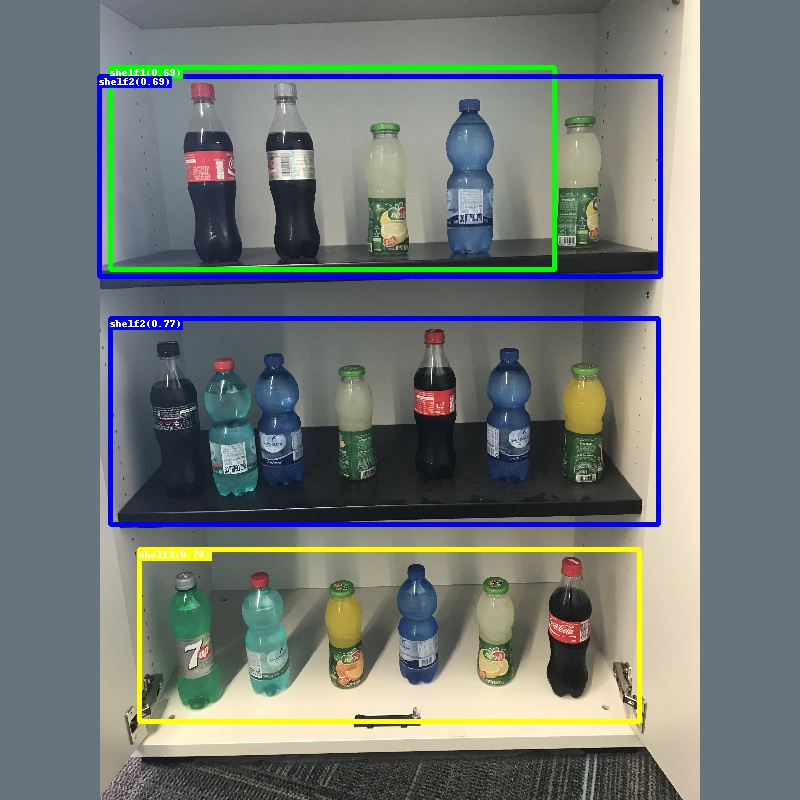

1 valid shelf1's detected 

[array([ 117.8 ,   72.01,  589.35,  286.2 ], dtype=float32)]


1 valid shelf3's detected 

[array([ 148.02,  583.46,  679.5 ,  766.83], dtype=float32)]


2 valid shelf2's detected 

[array([ 116.95,  338.55,  700.01,  557.58], dtype=float32), array([ 106.  ,   81.25,  701.32,  293.8 ], dtype=float32)]




In [46]:
invalid_image = 'dataset/Recognition/Test/Invalid/IMG_4245.JPG'
shelves_model_path = r'models/shelves/shelves.model'
evaluator, cfg, model_classes = load_detector(shelves_model_path)
bboxes, labels, scores = detect(invalid_image, evaluator, cfg)
D.display(D.Image(path.join(out_dir, path.basename(invalid_image)), width=800, height=800))

shelves = {"shelf1": [], "shelf2": [], "shelf3": []}

for i in range(len(bboxes)):
    if model_classes[labels[i]] != "__background__":
        shelves[model_classes[labels[i]]].append(bboxes[i])

for shelf in shelves:         
    print ("{} valid {}'s detected \n\n{}\n\n".format(len(shelves[shelf]), shelf, shelves[shelf]))

As you can see this model marked mulptile shelves as valid even though they were invalid.

### Challenge: Can you think of way we could use these boxes to tell that the policy is invalid?


# 3 Predict with Shelves Heuristic 

Our heurisitc will work as follows 

- We are going to find the use the min y1 and max y2 of each of the self classes
- We will confirm that the soda shelf is above the juice shelf which is above water shelf
- For each of the max's we will ensure that there are no other clases that are in between them


In [49]:
def predict_shelves(img_path):
    bounds = {}
    bboxes, labels, scores = detect(img_path, evaluator, cfg)
    shelves = {"shelf1": [], "shelf2": [], "shelf3": []}
    for i in range(len(bboxes)):
        if model_classes[labels[i]] != "__background__":
            shelves[model_classes[labels[i]]].append(bboxes[i])
    #  We are going to find the use the min y1 and max y2 of each of the tag classes
    for shelf in shelves:
        if len(shelves[shelf]) == 0:
            return False
        y1 = min(shelves[shelf], key=lambda b: b[1])[1]
        y2 = max(shelves[shelf], key=lambda b: b[3])[3]
        bounds[shelf] = {"y1":y1, "y2":y2} 
    # We will confirm that shelf1 is above shelf2 which is above shelf3
    if (bounds["shelf1"]["y1"] < bounds["shelf2"]["y1"]) and (bounds["shelf2"]["y1"] < bounds["shelf3"]["y1"]):
        # For each of the max's we will ensure that there are no other clases that are in between them
        for b in bounds.keys():
            for shelf_num in (set(bounds.keys()) - set([b])):
                for s in shelves[shelf_num]:
                    if s[1] > bounds[b]["y1"] and s[3] < bounds[b]["y2"]:
                        return False 
        return True
    return False

True


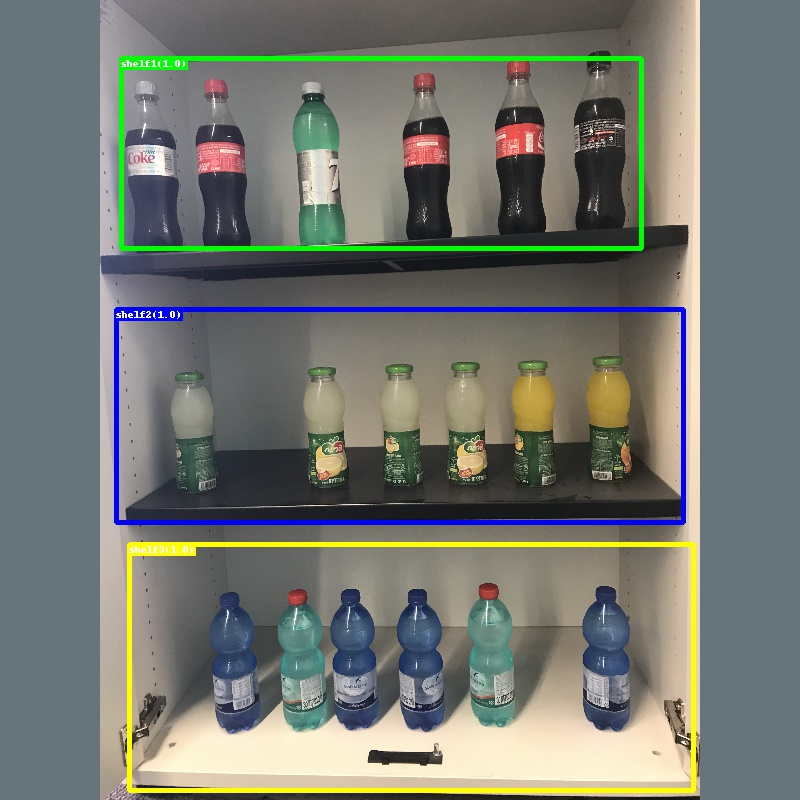

In [50]:
# true image 
valid_path = 'dataset/Recognition/Test/Valid/IMG_4154.JPG'

print(predict_shelves(valid_path))
D.display(D.Image(path.join(out_dir, path.basename(valid_path)), width=400, height=400))


# 4 Benchmark Shelf Heuristic

In [35]:
tokens = []
with open(testing_map, 'r') as input_file:
    tokens = [line.rstrip().split('\t') for line in input_file]    
y_true, y_pred = zip(*[(int(t[1]), int(predict_shelves(t[0]))) for t in tokens])

             precision    recall  f1-score   support

          0       1.00      0.77      0.87        30
          1       0.81      1.00      0.90        30

avg / total       0.91      0.88      0.88        60

Confusion matrix, without normalization
[[23  7]
 [ 0 30]]
Normalized confusion matrix
[[ 0.77  0.23]
 [ 0.    1.  ]]


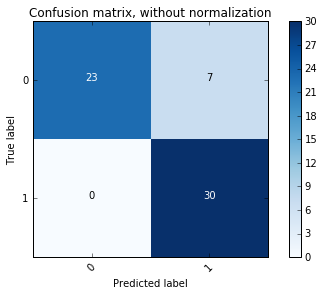

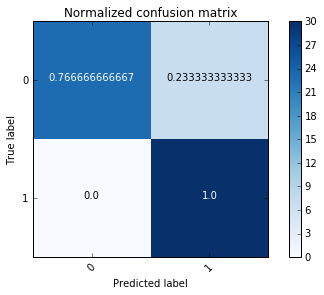

In [36]:
from cvworkshop_utils import classification_report

classification_report(y_true, y_pred)

# 5 Detect Bottles

So we see that detecting shelves provides better results than a vannila classification model what happens. **Yet this model is still worse that the custom vision Service model**. Let's see if we can improve these results by using another heuristic. 

Let's tag and detect bottles. 

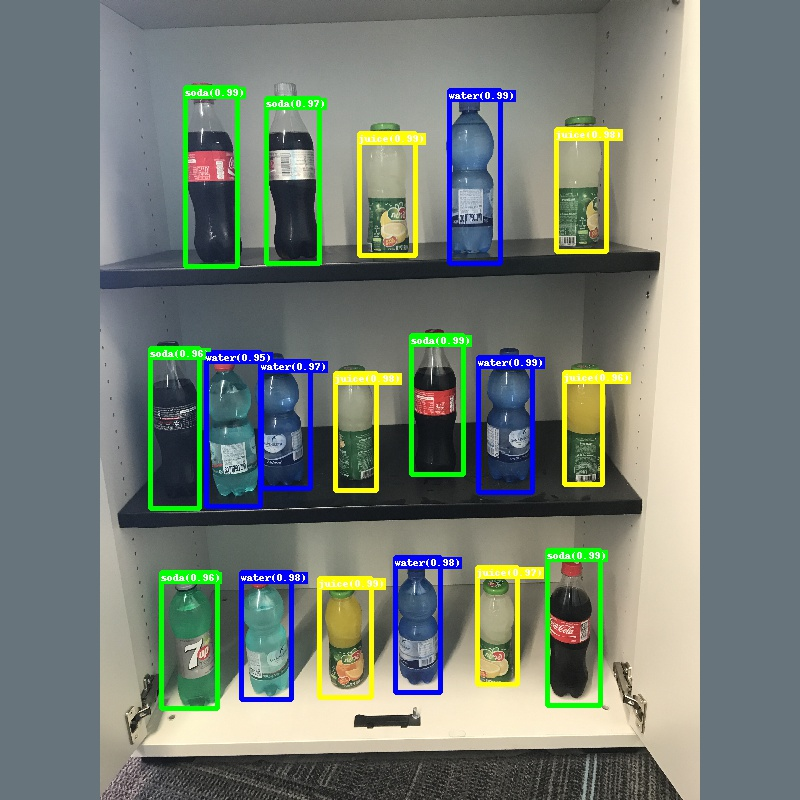

6 juice's detected 

[array([ 381.88,  141.89,  441.56,  271.96], dtype=float32), array([ 339.42,  614.52,  395.  ,  741.17], dtype=float32), array([ 591.7 ,  137.21,  644.63,  266.78], dtype=float32), array([ 356.18,  396.57,  400.01,  520.97], dtype=float32), array([ 507.72,  603.21,  549.89,  727.72], dtype=float32), array([ 599.78,  395.35,  640.33,  514.37], dtype=float32)]


6 soda's detected 

[array([ 437.4 ,  356.35,  492.59,  504.24], dtype=float32), array([ 581.24,  584.62,  637.97,  749.29], dtype=float32), array([ 197.61,   92.86,  252.37,  283.3 ], dtype=float32), array([ 283.  ,  104.95,  339.98,  279.59], dtype=float32), array([ 171.46,  608.49,  230.99,  752.56], dtype=float32), array([ 159.38,  370.52,  211.51,  540.72], dtype=float32)]


6 water's detected 

[array([ 507.89,  379.39,  565.61,  523.02], dtype=float32), array([ 477.74,   96.12,  531.97,  279.74], dtype=float32), array([ 256.16,  608.53,  310.22,  743.46], dtype=float32), array([ 420.21,  591.87,  468.2

In [37]:
beverage_model_path =  'models/bottles/bottles.model'
evaluator, cfg, model_classes = load_detector(beverage_model_path)
bboxes, labels, scores = detect(invalid_image, evaluator, cfg)
D.display(D.Image(path.join(out_dir, path.basename(invalid_image)), width=800, height=800))

beverages = {"soda": [], "water": [], "juice": []}

for i in range(len(bboxes)):
    if model_classes[labels[i]] != "__background__":
        beverages[model_classes[labels[i]]].append(bboxes[i])

for bev in beverages:         
    print ("{} {}'s detected \n\n{}\n\n".format(len(beverages[bev]), bev, beverages[bev]))

# 6 Predict with Bottle Heuristic

Can you think of way we could use these boxes to tell that the policy is invalid?

Our heurisitc will work as follows 

- We are going to find the use the min y1 and max y2 of each of the tag classes
- We will confirm that soda is above juice which is above water
- For each of the max's we will ensure that there are no other clases that are in between them


In [38]:
def predict_bottles(img_path):
    bounds = {}
    bboxes, labels, scores = detect(img_path, evaluator, cfg)
    beverages = {"soda": [], "water": [], "juice": []}
    for i in range(len(bboxes)):
        if model_classes[labels[i]] != "__background__":
            beverages[model_classes[labels[i]]].append(bboxes[i])
    #  We are going to find the use the min y1 and max y2 of each of the tag classes
    for bev in beverages:
        if len(beverages[bev]) == 0:
            return False
        y1 = min(beverages[bev], key=lambda b: b[1])[1]
        y2 = max(beverages[bev], key=lambda b: b[3])[3]
        bounds[bev] = {"y1":y1, "y2":y2} 
    # We will confirm that soda is above juice which is above water
    if (bounds["soda"]["y1"] < bounds["juice"]["y1"]) and (bounds["juice"]["y1"] < bounds["water"]["y1"]):
        # For each of the max's we will ensure that there are no other clases that are in between them
        for b in bounds.keys():
            for bev_type in (set(bounds.keys()) - set([b])):
                for bev in beverages[bev_type]:
                    if bev[1] > bounds[b]["y1"] and bev[3] < bounds[b]["y2"]:
                        return False 
        return True
    else:
        return False


True


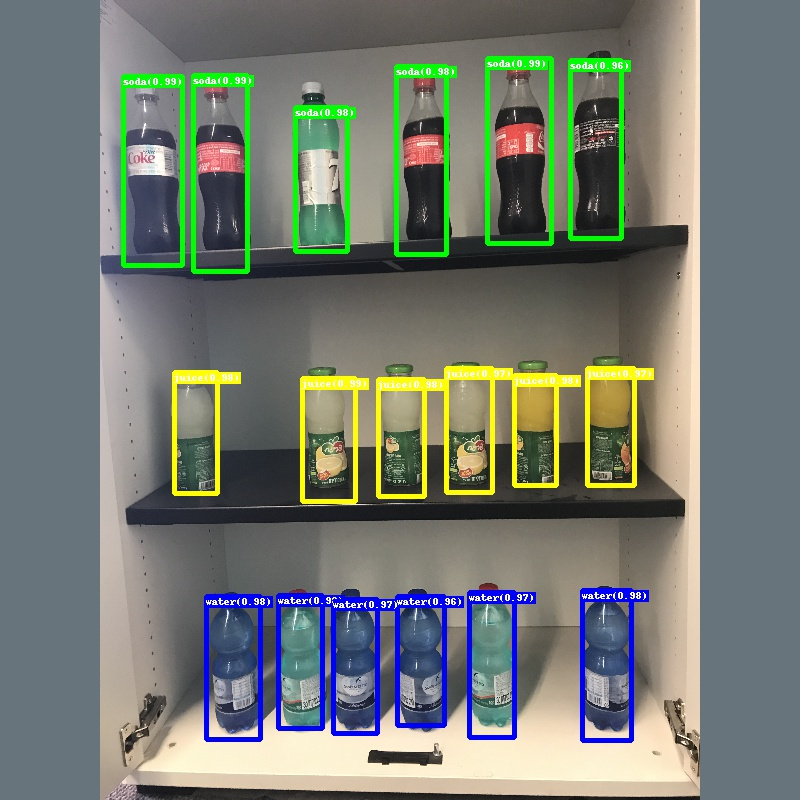

In [42]:
# true image 
print(predict_bottles(valid_path))
D.display(D.Image(path.join(out_dir, path.basename(valid_path)), width=800, height=800))



# 7 Benchmark Bottle Heuristic

In [43]:
tokens = []
with open(testing_map, 'r') as input_file:
    tokens = [line.rstrip().split('\t') for line in input_file]    
y_true, y_pred = zip(*[(int(t[1]), int(predict_bottles(t[0]))) for t in tokens])


             precision    recall  f1-score   support

          0       1.00      1.00      1.00        30
          1       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00        60

Confusion matrix, without normalization
[[30  0]
 [ 0 30]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


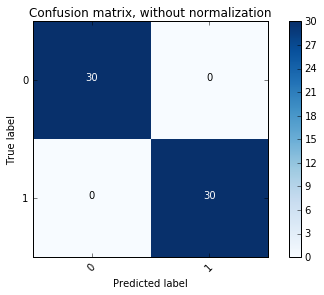

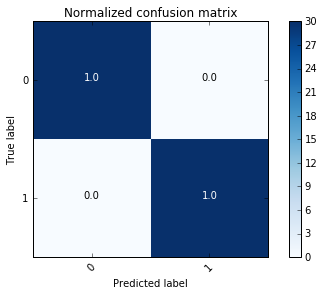

In [45]:
classification_report(y_true, y_pred)

# Conclusions 

We can see that using object detection with a good heuristic can out preform the Custom Vision Service for certain tasks. However it's important to think about the trade offs and work required to annotate our data and build an object detection model. 

Even thought the bottle model worked the best in this case we saw that we could get relatively strong results by just tagging valid shelves. While tagging shelves even though we might have to tag more shelves to get more data

### Challenge: can you thing of other trade offs and advantages between the two object detection approaches?

